Reported by: Natasha Flores (24-april-2025)

Exporting REACT results to shapefiles (a shapefile per year in this case)

In [2]:

import os
import sys
import xugrid as xu
import xarray as xr
sys.path.insert(1, '../library')
from DEcoImpact_exp_func import DEIOutput

In [5]:
#configuration

#list with input locations of D-Eco Impact export file that needs to be converted
list_ds_in = [r'../results/SpongeWorks/results_REACT_WFLOW_calibrate_flooding_zones_Step2_Vecht_2017_2023.nc'] 

# list with variables that need to be exported to shapefile. Note, these should only contain faces as axes (no time or depth etc).
rename_list_variabels = {'pred_category_zone0_perc'  : 'Zone 0', # 0% 50% or 100% predicted
                         'pred_category_zone1_perc'  : 'Zone 1',
                         'pred_category_zone2_perc'  : 'Zone 2',
                         'pred_category_zone3_perc'  : 'Zone 3',
                         'pred_category_zone4_perc'  : 'Zone 4',
                         'pred_category_zone5_perc'  : 'Zone 5',
                         'pred_category_Hills_perc'  : 'Hills',
                         }

#output path location for shapefile data created 
output_path = r'example_output_data/shapefile_output_Inundation_Zones'

#make sure the folders to output path exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

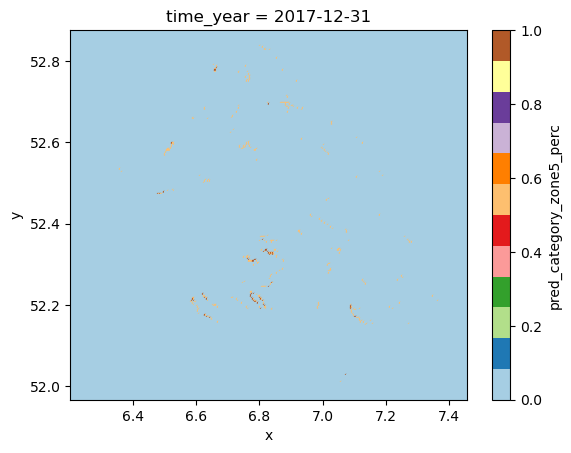

In [6]:
#read and show result
#Show result of one specific year for 
uda_map = xu.open_mfdataset(list_ds_in)
uda_map["pred_category_zone5_perc"].sel(time_year= "2017-12-31 00:00:00").ugrid.plot(cmap = "Paired")


In [7]:
#export a seperate Netcdf per year to convert to shapefile and adapt variable names so they fit the shapefile column
uda_map = uda_map.rename_vars(rename_list_variabels)
subsetted_uda_map = uda_map[list(rename_list_variabels.values())]

list_ds_in_per_year = []

#export a netcdf file per year calculated and store the path
for time_year_value in uda_map.time_year.values:
    time_subsetted_uda_map = subsetted_uda_map.sel(time_year = time_year_value)
    year = time_year_value.astype('datetime64[Y]').astype(int) + 1970
    file_path = "results/to_shape_results_REACT_WFLOW_calibrate_flooding_zones_Step2_" + str(year) + ".nc"
    list_ds_in_per_year.append(file_path)
    time_subsetted_uda_map.ugrid.to_netcdf(file_path)


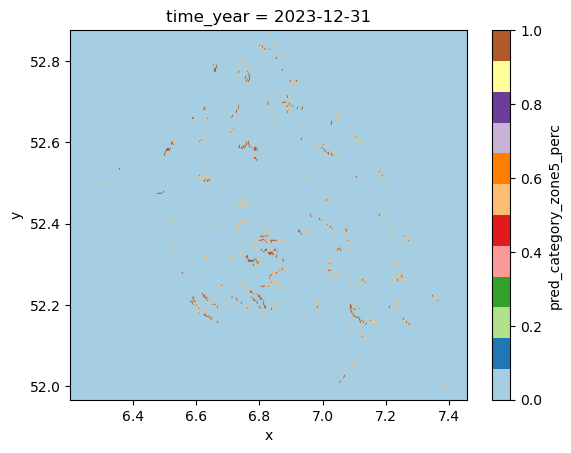

In [8]:
#read and show result
#Show result of one specific year for 
uda_map_test = xu.open_mfdataset(list_ds_in_per_year[-1])
uda_map_test["Zone 5"].ugrid.plot(cmap = "Paired")


In [9]:
#initialize
DEIresults = DEIOutput()
cwd = os.getcwd()
DEIresults.set_root(root = cwd)

#Add paths to the result NetCDF(s) 
DEIresults.set_paths_to_DEIresults(input_list_path = list_ds_in_per_year[0:])

#Export to Shapefile
DEIresults.translate_UgridNetCDFs_to_Shape(
    list_variables = list(rename_list_variabels.values()),
    output_path = output_path
)

print("Done.")

Start with results/to_shape_results_REACT_WFLOW_calibrate_flooding_zones_Step2_2017.nc
Exported example_output_data/shapefile_output_Inundation_Zones\to_shape_results_REACT_WFLOW_calibrate_flooding_zones_Step2_2017
Start with results/to_shape_results_REACT_WFLOW_calibrate_flooding_zones_Step2_2018.nc
Exported example_output_data/shapefile_output_Inundation_Zones\to_shape_results_REACT_WFLOW_calibrate_flooding_zones_Step2_2018
Start with results/to_shape_results_REACT_WFLOW_calibrate_flooding_zones_Step2_2019.nc
Exported example_output_data/shapefile_output_Inundation_Zones\to_shape_results_REACT_WFLOW_calibrate_flooding_zones_Step2_2019
Start with results/to_shape_results_REACT_WFLOW_calibrate_flooding_zones_Step2_2020.nc
Exported example_output_data/shapefile_output_Inundation_Zones\to_shape_results_REACT_WFLOW_calibrate_flooding_zones_Step2_2020
Start with results/to_shape_results_REACT_WFLOW_calibrate_flooding_zones_Step2_2021.nc
Exported example_output_data/shapefile_output_Inundat

In [10]:
def postprocess_inundation_zones(output_path):
    """
    Summarise inundation zone shapefiles (values: 0, 0.5, 1) exported by DEIOutput, using
    ONLY the output shapefiles (recursively found under output_path).

    Computes:
      1) Per-year statistics per variable and value:
         - count of faces
         - total area (m²)
         - percent of assessed area (%), where assessed area = sum of areas of non-NaN faces that year

      2) Cross-year certainty per face (for each variable):
         - most frequent value in {0, 0.5, 1} across years (mode)
         - certainty proportion in [0, 1]: (max count across values) / (years observed)
         - counts per value: cnt_0, cnt_0.5, cnt_1
         - years observed (yrs_seen)

    Outputs (NO shapefile written):
      - CSVs:
          zone_stats_per_year.csv               # per-year count/area/% per variable & value
          zone_certainty_per_face.csv           # per-face certainty (proportion 0..1) and counts
      - Plots:
          zone_pct_area_stacked_by_year.png     # % area by value per year (stacked bars)
          zone_area_m2_by_year.png              # area (m²) by value per year (lines)
          zone_certainty_distribution.png       # histogram of certainty proportions (0..1)

    Prints a small example of certainty results (first 8 rows).
    """
    import os, re, warnings
    import numpy as np
    import pandas as pd
    import geopandas as gpd
    import matplotlib.pyplot as plt

    # Values expected in the variables
    VALUES = [0.0, 0.5, 1.0]

    # Output files
    csv_area = os.path.join(output_path, "zone_stats_per_year.csv")
    csv_cert = os.path.join(output_path, "zone_certainty_per_face.csv")
    png_stacked = os.path.join(output_path, "zone_pct_area_stacked_by_year.png")
    png_lines = os.path.join(output_path, "zone_area_m2_by_year.png")
    png_cert_hist = os.path.join(output_path, "zone_certainty_distribution.png")

    os.makedirs(output_path, exist_ok=True)

    # ---- 1) Find per-year shapefiles (recursively), ignore 'complete_file.shp' ----
    year_to_paths = {}
    for root, _, files in os.walk(output_path):
        for f in files:
            if f.lower().endswith(".shp") and f != "complete_file.shp":
                m = re.search(r"(19|20)\d{2}", f)
                year = int(m.group(0)) if m else None
                if year is None:
                    m2 = re.search(r"(19|20)\d{2}", os.path.basename(root))
                    year = int(m2.group(0)) if m2 else None
                if year is not None:
                    year_to_paths.setdefault(year, []).append(os.path.join(root, f))

    if not year_to_paths:
        raise FileNotFoundError(f"No shapefiles found under {output_path}")

    years = sorted(year_to_paths.keys())
    print(f"Found shapefiles for years: {years}")

    # ---- 2) Load shapefiles -> project to EPSG:28992 and compute area ----
    per_year_gdf = {}
    for y in years:
        # Pick the first path for that year (or implement a chooser heuristic if multiples exist)
        shp = gpd.read_file(year_to_paths[y][0])
        if shp.crs is None:
            shp = shp.set_crs(4326)  # assume lon/lat if missing
        if shp.crs.to_epsg() != 28992:
            shp = shp.to_crs(28992)
        shp["area_m2"] = shp.geometry.area.astype("float64")
        per_year_gdf[y] = shp

    # Variables are all non-geometry attributes (exclude the area_m2 field we just added)
    variables = [c for c in per_year_gdf[years[0]].columns if c not in ["geometry", "area_m2"]]

    # ---- 3) Per-year stats: count, area, % area for each value ----
    records = []
    for y in years:
        shp = per_year_gdf[y]
        for var in variables:
            col = pd.to_numeric(shp[var], errors="coerce")
            valid = col.notna()
            assessed_area = shp.loc[valid, "area_m2"].sum()
            for v in VALUES:
                sel = valid & (col == v)
                count_v = int(sel.sum())
                area_v = float(shp.loc[sel, "area_m2"].sum())
                pct_area = float(100.0 * area_v / assessed_area) if assessed_area > 0 else 0.0
                records.append({
                    "year": y,
                    "variable": var,
                    "value": v,
                    "count": count_v,                 # <<< count included
                    "area_m2": area_v,
                    "pct_area": pct_area,
                    "assessed_area_m2": float(assessed_area)
                })

    df_yearly = pd.DataFrame.from_records(records)
    df_yearly.to_csv(csv_area, index=False)
    print(f"Wrote per-year stats CSV: {csv_area}")

    # ---- Plots: % area stacked by year ----
    pivot_pct = (
        df_yearly.pivot_table(index="year", columns="value", values="pct_area", aggfunc="mean")
        .reindex(columns=VALUES)
        .fillna(0)
    )
    ax = pivot_pct.plot(
        kind="bar", stacked=True, figsize=(12, 6),
        color=["#4C78A8", "#F58518", "#54A24B"], width=0.85
    )
    ax.set_ylabel("% of assessed area"); ax.set_xlabel("Year")
    ax.set_title("Percent area by value (0, 0.5, 1) per year")
    ax.legend(title="Value", bbox_to_anchor=(1.02, 1.0), loc="upper left", frameon=False)
    plt.tight_layout(); plt.savefig(png_stacked, dpi=200); plt.close()
    print(f"Wrote plot: {png_stacked}")

    # ---- Plots: area (m²) by year ----
    pivot_area = (
        df_yearly.pivot_table(index="year", columns="value", values="area_m2", aggfunc="sum")
        .reindex(columns=VALUES)
        .fillna(0)
    )
    ax = pivot_area.plot(
        kind="line", figsize=(12, 6), marker="o",
        color=["#4C78A8", "#F58518", "#54A24B"]
    )
    ax.set_ylabel("Area (m²)"); ax.set_xlabel("Year")
    ax.set_title("Area by value (0, 0.5, 1) per year")
    ax.legend(title="Value", bbox_to_anchor=(1.02, 1.0), loc="upper left", frameon=False)
    plt.tight_layout(); plt.savefig(png_lines, dpi=200); plt.close()
    print(f"Wrote plot: {png_lines}")

    # ---- 4) Cross-year certainty per face (proportion 0..1) ----
    # Align by row order (assumes exporter preserves face order across years)
    nfaces = len(per_year_gdf[years[0]])
    vals_matrix = np.zeros((nfaces, len(years), len(variables)))
    vals_matrix[:] = np.nan

    for iy, y in enumerate(years):
        shp = per_year_gdf[y]
        for iv, var in enumerate(variables):
            vals_matrix[:, iy, iv] = pd.to_numeric(shp[var], errors="coerce").to_numpy()

    certainty_records = []
    for iv, var in enumerate(variables):
        vals = vals_matrix[:, :, iv]
        valid = ~np.isnan(vals)
        years_seen = valid.sum(axis=1)  # number of observed years per face
        # counts per value
        cnt0   = np.sum(vals == 0.0, axis=1)
        cnt05  = np.sum(vals == 0.5, axis=1)
        cnt1   = np.sum(vals == 1.0, axis=1)
        maxcnt = np.max(np.column_stack([cnt0, cnt05, cnt1]), axis=1)
        # --- certainty in [0, 1] ---
        denom = np.where(years_seen == 0, 1, years_seen)
        cert_prop = (maxcnt / denom).astype("float64")

        # mode value (tie-breaking: chooses first among [0, 0.5, 1] in case of ties)
        best_idx = np.argmax(np.column_stack([cnt0, cnt05, cnt1]), axis=1)
        values_order = np.array([0.0, 0.5, 1.0])
        best_value = values_order[best_idx]

        for i in range(nfaces):
            certainty_records.append({
                "face_index": i,
                "variable": var,
                "yrs_seen": int(years_seen[i]),
                "cert_value": float(best_value[i]),
                "cert_prop": float(cert_prop[i]),   # <<< proportion in [0, 1]
                "cnt_0": int(cnt0[i]),
                "cnt_0_5": int(cnt05[i]),          # use underscore for shapefile-safe style CSV headers
                "cnt_1": int(cnt1[i]),
            })

    df_cert = pd.DataFrame.from_records(certainty_records)
    df_cert.to_csv(csv_cert, index=False)
    print(f"Wrote certainty CSV: {csv_cert}")

    # ---- Certainty distribution (proportion 0..1) ----
    ax = df_cert["cert_prop"].plot(kind="hist", bins=20, figsize=(10, 5), color="#4C78A8")
    ax.set_xlabel("Certainty (proportion 0–1)")
    ax.set_title("Distribution of certainty (proportion) across faces")
    plt.tight_layout(); plt.savefig(png_cert_hist, dpi=200); plt.close()
    print(f"Wrote plot: {png_cert_hist}")

    # ---- Print example rows ----
    print("\nExample certainty results (first 8 rows):")
    print(df_cert.head(8).to_string(index=False))

In [11]:
postprocess_inundation_zones(output_path)

Found shapefiles for years: [2017, 2018, 2019, 2020, 2021, 2022, 2023]
Wrote per-year stats CSV: example_output_data/shapefile_output_Inundation_Zones\zone_stats_per_year.csv
Wrote plot: example_output_data/shapefile_output_Inundation_Zones\zone_pct_area_stacked_by_year.png
Wrote plot: example_output_data/shapefile_output_Inundation_Zones\zone_area_m2_by_year.png
Wrote certainty CSV: example_output_data/shapefile_output_Inundation_Zones\zone_certainty_per_face.csv
Wrote plot: example_output_data/shapefile_output_Inundation_Zones\zone_certainty_distribution.png

Example certainty results (first 8 rows):
 face_index variable  yrs_seen  cert_value  cert_prop  cnt_0  cnt_0_5  cnt_1
          0   Zone 0         7         0.0        1.0      7        0      0
          1   Zone 0         7         0.0        1.0      7        0      0
          2   Zone 0         7         0.0        1.0      7        0      0
          3   Zone 0         7         0.0        1.0      7        0      0
     

In [ ]:
### This is a simple summary that counts the cells per results in the shapefiles ###
# --- Count certainty values per year from exported shapefiles (period decimals) ---
from pathlib import Path
import re
import pandas as pd
import geopandas as gpd
import numpy as np

# ---------------------------------------------------------------------------
# Inputs (reuse existing globals from your script if available)
# ---------------------------------------------------------------------------
try:
    output_dir = Path(output_path)  # from your script
except NameError:
    output_dir = Path("example_output_data/shapefile_output_Inundation_Zones")

try:
    target_vars = list(rename_list_variabels.values())  # from your script
except NameError:
    target_vars = ["Zone 0", "Zone 1", "Zone 2", "Zone 3", "Zone 4", "Zone 5", "Hills"]

# Certainty codes to count (with decimal periods)
CODES_TO_COUNT = [0.0, 0.5, 1.0]
# Tolerance for float comparison
EPS = 1e-6

# Regex to extract year from filename (e.g., "..._2020.shp", "...2020-12-31.shp")
year_pattern = re.compile(r'(?P<year>19\d{2}|20\d{2})')

def extract_year_from_name(pathlike) -> int | None:
    stem = Path(pathlike).stem
    m = year_pattern.search(stem)
    return int(m.group('year')) if m else None

def _normalize_for_match(name: str) -> str:
    """Normalized variant (lower, no spaces/underscores) for fuzzy matching."""
    return re.sub(r'[_\s]+', '', name.lower())

def find_matching_column(gdf: gpd.GeoDataFrame, var_name: str) -> str | None:
    """
    Find the column corresponding to `var_name`,
    robust to spaces/underscores, DBF 10-char truncation, and case.
    """
    cols = list(gdf.columns)
    if var_name in cols:
        return var_name

    candidates = [
        var_name.replace(" ", "_"),
        var_name.replace(" ", ""),
        var_name.replace(" ", "_")[:10],  # DBF truncation
        var_name.replace(" ", "")[:10],
    ]
    for cand in candidates:
        if cand in cols:
            return cand

    norm_target = _normalize_for_match(var_name)[:10]
    for c in cols:
        if _normalize_for_match(c)[:10] == norm_target:
            return c
    return None

def to_numeric_periods_only(series: pd.Series) -> pd.Series:
    """
    Convert to numeric assuming period (.) decimals.
    Any value containing a comma is considered invalid and becomes NaN.
    """
    # If already numeric, coerce to float
    if pd.api.types.is_numeric_dtype(series):
        return pd.to_numeric(series, errors='coerce').astype(float)

    s = series.astype(str).str.strip()
    # Drop empty strings
    s = s.replace({"": np.nan})
    # Reject any value that contains a comma (enforces periods-only policy)
    s = s.where(~s.str.contains(",", na=True), other=np.nan)
    return pd.to_numeric(s, errors='coerce').astype(float)

def count_with_tolerance(values: pd.Series, targets: list[float], eps: float = EPS) -> dict:
    """Count occurrences close to each target within eps."""
    counts = {}
    arr = values.to_numpy(dtype=float)
    finite = np.isfinite(arr)
    for t in targets:
        counts[t] = int(np.sum(finite & (np.abs(arr - t) <= eps)))
    return counts

# ---------------------------------------------------------------------------
# Scan shapefiles and collect counts
# ---------------------------------------------------------------------------
rows = []

shp_files = list(output_dir.rglob("*.shp"))
if not shp_files:
    print(f"⚠️ No shapefiles found under: {output_dir.resolve()}")

for shp in shp_files:
    try:
        gdf = gpd.read_file(shp)
    except Exception as e:
        print(f"⚠️ Could not read {shp}: {e}")
        continue

    year = extract_year_from_name(shp)

    for var in target_vars:
        col = find_matching_column(gdf, var)
        if col is None:
            # Not all shapefiles will carry all variables; skip quietly
            continue

        # Convert attribute values to numeric (period decimals only) and drop NaN
        s_num = to_numeric_periods_only(gdf[col]).dropna()

        # Counts with tolerance
        cdict = count_with_tolerance(s_num, CODES_TO_COUNT, eps=EPS)

        row = {
            "variable": var,
            "year": year,   # could be None if no year in filename
            "file": str(shp),
            "count_total_numeric": int(len(s_num)),
        }
        # Use CSV-friendly column names (0 -> count_0, 0.5 -> count_0_5, 1 -> count_1)
        for code in CODES_TO_COUNT:
            safe = str(code).replace(".", "_")
            row[f"count_{safe}"] = cdict[code]

        rows.append(row)

# ---------------------------------------------------------------------------
# Summaries & outputs
# ---------------------------------------------------------------------------
summary_df = pd.DataFrame(rows)

if not summary_df.empty:
    # Ensure all count columns exist (even if absent in some files)
    for code in CODES_TO_COUNT:
        safe = str(code).replace(".", "_")
        colname = f"count_{safe}"
        if colname not in summary_df.columns:
            summary_df[colname] = 0

    count_cols = [f"count_{str(c).replace('.', '_')}" for c in CODES_TO_COUNT] + ["count_total_numeric"]

    # Per-year summary (summing across files per variable-year)
    per_year = (
        summary_df
        .groupby(["variable", "year"], dropna=False)[count_cols]
        .sum()
        .reset_index()
        .sort_values(["variable", "year"], kind="stable")
    )

    # Overall summary per variable (across all years/files)
    overall = (
        summary_df
        .groupby("variable")[count_cols]
        .sum()
        .reset_index()
        .sort_values("variable", kind="stable")
    )

    # Write outputs next to shapefiles
    out_csv_per_year = output_dir / "summary_counts_per_year.csv"
    out_csv_overall  = output_dir / "summary_counts_overall.csv"
    per_year.to_csv(out_csv_per_year, index=False)
    overall.to_csv(out_csv_overall, index=False)

    # Display small preview
    print("\n✅ Summary written:")
    print(f"  - {out_csv_per_year}")
    print(f"  - {out_csv_overall}")
    print("\nPer-year preview:")
    print(per_year.head(10).to_string(index=False))
    print("\nOverall:")
    print(overall.to_string(index=False))
else:
    print(
        "ℹ️ No variable counts were collected. "
        f"Check that shapefiles under {output_dir.resolve()} contain any of: {target_vars} "
        "and that the fields use period decimals (e.g., 0.5), not commas."
    )


KeyboardInterrupt: 